In [1]:
pip install -q 'gwosc==0.7.1'

In [2]:
pip install -q pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━

In [3]:
pip install -q 'gwpy==3.0.12'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 22.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from pycbc.types import TimeSeries
from pycbc.filter import matched_filter, sigma


/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [5]:
# Step 1: Generate the GW signal
sample_rate = 2048
delta_t = 1.0 / sample_rate
data_length = 8  # seconds
flow = 20.0

hp, _ = get_td_waveform(approximant="SEOBNRv4",
                        mass1=30, mass2=30,
                        delta_t=delta_t, f_lower=flow)


**Why we need to normalize?**<br>

We need to normalize gravitatonal wave hp so that is L2 norm(energy) is equal to 1 so that SNR is correctly scaled.

---



**What hp.conj() is doing?**<br>
A complex number is a number of the form:
z=a+ib <br>
The complex conjugate of z is:
z∗=a−ib<br>

---



 <b> When the the waveform is Real and complex?</b><br>
 Time-domain waveforms (get_td_waveform) from models like SEOBNRv4, TaylorT4, etc., are usually real-valued. These waveforms represent the physical strain over time, and there's no imaginary part.<br>
 (Here we are using time domain wavefrom so hp\*hp.conj() is same as hp\*\*2  )

Frequency-domain waveforms (get_fd_waveform) or after Fourier transforms, however, are often complex-valued, because the frequency representation contains both magnitude and phase<br>
<br>
in place of hp\*hp.conj() we can also use sum of dot product (np.vdot(hp,hp)) or simply hp\*hp for time domain waveform.<br>

---


<br>
**Why to multiply hp with hp.conj()?**
 If hp is real (just normal time-domain data) So it’s just squaring the signal.
 If hp is complex (which can happen in frequency-domain processing) This gives the magnitude squared (|hp|\*\*2) of the complex number at each point.

---



**Why to multiply with timestamp( hp.delta_t )?**
In place of using integral of hp in time domain which is given by :-<br>

**∫ |hp(t)|\*\*2 dt**<br>
which gives the total energy of the in the time domain.<br>

we are using sum of hp\*\* multiplied by timeinterval(delta_t) given by :-<br>
∑​∣hp​∣\*\*2 ⋅Δt
we are doing this because we integrate when there continous sampling of data at given time but here hp is descrete sampled at every (0.000488 defined above 1/sample_rate) which gives total energy in descrete time domain.<br>
 <br>

---




then we take root because ∑​∣hp​∣\*\*2 ⋅Δt it gives the energy of signal but we need proportional to the amplitude of the signal.



In [6]:

norm_factor = np.sqrt(abs(float((hp * hp.conj()).sum() * hp.delta_t)))
hp = hp / norm_factor

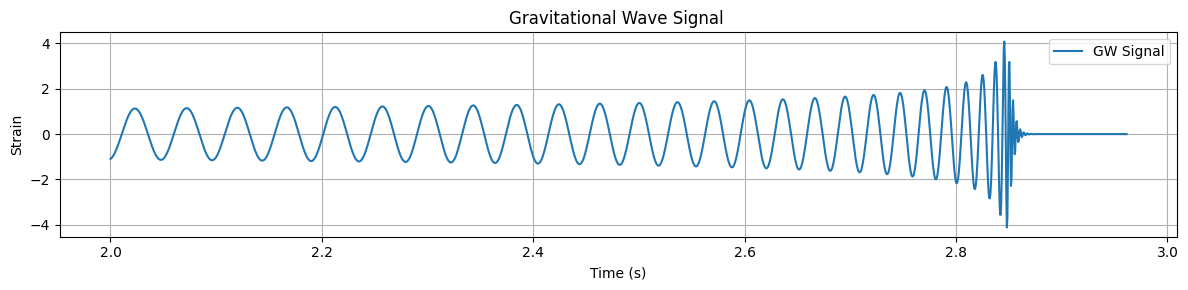

In [7]:

hp_start_time = 2.0
hp.start_time = hp_start_time

# Plot the GW signal
plt.figure(figsize=(12, 3))
plt.plot(hp.sample_times, hp, label='GW Signal')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Gravitational Wave Signal ")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
#Generate colored noise
flen = int(sample_rate / (2 * (1.0 / data_length))) + 1

psd = aLIGOZeroDetHighPower(flen, 1.0 / data_length, flow)
ts_noise = noise_from_psd(sample_rate * data_length, delta_t, psd, seed=123)


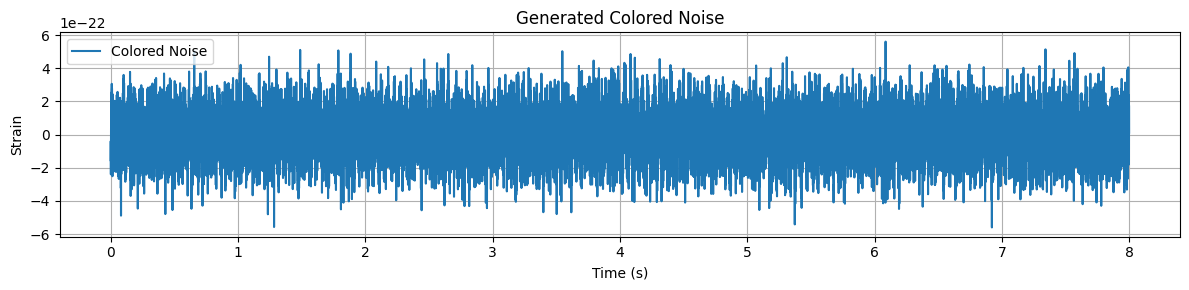

In [9]:
# Plot the colored noise
plt.figure(figsize=(12, 3))
plt.plot(ts_noise.sample_times, ts_noise, label='Colored Noise')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Generated Colored Noise")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
injection_index = int(hp_start_time / delta_t)

signal = hp.copy()
signal *= 1e-22# scale to physical strain level
injected_data = ts_noise.copy()
injected_data[injection_index:injection_index + len(signal)] += signal.numpy()

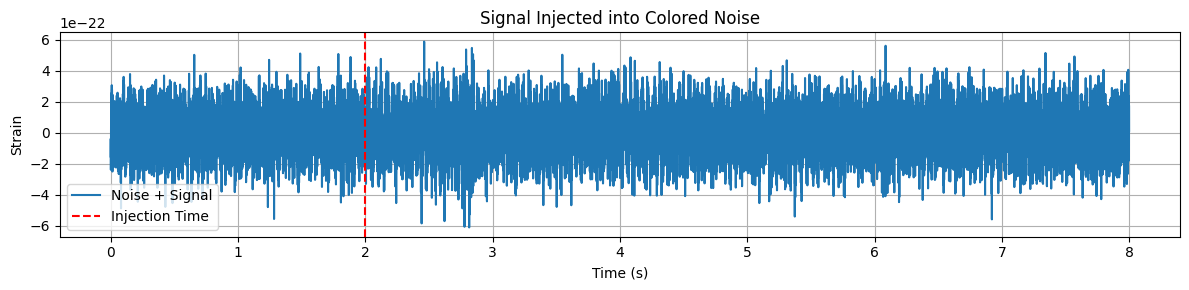

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(injected_data.sample_times, injected_data, label='Noise + Signal')
plt.axvline(hp_start_time, color='r', linestyle='--', label='Injection Time')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Signal Injected into Colored Noise")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
hp_padded = TimeSeries(np.zeros(len(injected_data)), delta_t=hp.delta_t, epoch=injected_data.start_time)

# Insert the waveform into the padded array
hp_padded[:len(hp)] = hp

In [13]:
snr = matched_filter(hp_padded, injected_data, psd=psd, low_frequency_cutoff=flow)


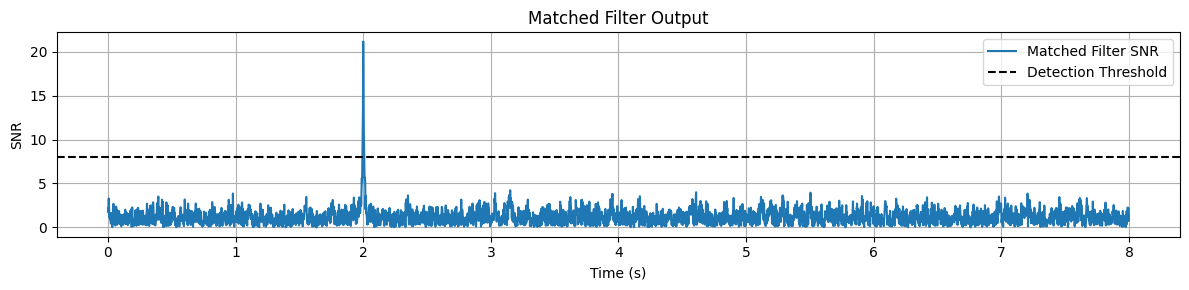

In [14]:
plt.figure(figsize=(12, 3))
plt.plot(snr.sample_times, abs(snr), label="Matched Filter SNR")
plt.axhline(8, color='k', linestyle='--', label='Detection Threshold')
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.title("Matched Filter Output")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
peak_time = snr.sample_times[peak]
dt = peak_time - injected_data.start_time
print(f"Peak SNR: {abs(snr)[peak]:.1f} at {peak_time:.2f}s")
# Use the same padded waveform used in matched_filter
aligned = hp_padded.cyclic_time_shift(dt)

# Convert aligned template to frequency domain with correct delta_f
aligned_f = aligned.to_frequencyseries()


Peak SNR: 21.1 at 2.00s
